In [21]:
import pandas as pd
import numpy as np
import os
import re
import string
from collections import Counter
import random

import copy
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import iplot
import plotly.graph_objs as go
import plotly.express as px

from typing import Union # This is for function annotation.
from tqdm import tqdm # Shows progress bar when doing loops, used in training data

import spacy
from spacy.util import compounding
from spacy.util import minibatch

import cufflinks # plotly wrapper, give acccess to .iplot()
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

# Sources
https://www.kaggle.com/parulpandey/eda-and-preprocessing-for-bert

https://www.kaggle.com/akshitsharma206/tweet-sentiment-extraction-starter-code-eda

In [2]:
# !pip install go

In [3]:
os.listdir()

['.DS_Store',
 'test.csv',
 'train.csv',
 '.ipynb_checkpoints',
 'Tweet Sentiment.ipynb',
 '.git',
 'sample_submission.csv']

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
ex_submission = pd.read_csv('sample_submission.csv')

# Objective
Given a tweet and a sentiment, what are the selected_text values?

In [5]:
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [6]:
print(train.isnull().sum())
print(test.isnull().sum())

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64
textID       0
text         0
sentiment    0
dtype: int64


In [7]:
test.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [8]:
# Only one missing value in the training set, removing that entry.
train.dropna(inplace = True)

In [9]:
train.sentiment.value_counts()

neutral     11117
positive     8582
negative     7781
Name: sentiment, dtype: int64

In [10]:
train.sentiment.value_counts(normalize = True)

neutral     0.404549
positive    0.312300
negative    0.283151
Name: sentiment, dtype: float64

In [11]:
# This is just a nicer version of the above cell.
dist = train.groupby('sentiment').count()['text'].reset_index().sort_values(by = 'text', ascending = False)
dist.style.background_gradient(cmap = 'Blues')

,sentiment,text
1,neutral,11117
2,positive,8582
0,negative,7781


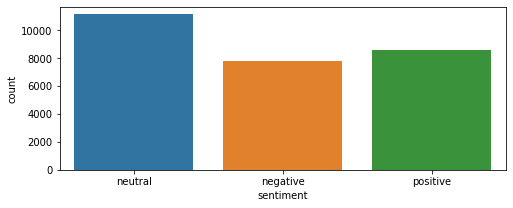

In [12]:
#Making a count plot
plt.figure(figsize = (8,3))
sns.countplot(x = 'sentiment', data = train)

In [118]:
# Trying to use function annotation here.
def clean_text(text : str) -> str:
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower() # make everythng lowercase
    text = re.sub('\[.*?\]', '', text) # remove text in squre brackets
    text = re.sub('https?://\S+|www\.\S+', '', text) # remove website links
    text = re.sub('<.*?>+', '', text) # remove anything within <...>
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # remove punctuation
    text = re.sub('\n', '', text) # remove new line 
    text = re.sub('\w*\d\w*', '', text) # remove words containing numbers
    return text

# This takes a string, uses the above clean_text function, then tokenizes the words into a list, then joins the list
def text_preprocessing(text : str) -> str:
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    nopunc = clean_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    
    ### Should we remove replicated text?
    ### The below will lose order, if used verify that is not important.
    ### If we are using the Jaccard score, then this will not matter.
    # tokenized_text = list(set(tokenized_text))
    
    ### Where (if at all) should we remove the stop words, i.e., before we clean the text?  Dont and don't are diff.
    #tokenized_text = [w for w in tokenized_text if w not in stopwords.words('english')]
    
    combined_text = ' '.join(tokenized_text)
    return combined_text

# This will calculate the similarity of two strings.  Above are other methods for calculating these similarities. 
def jaccard(str1 : str, str2 : str) -> float: 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

# This will remove the topwords, returning a list or a string, user coice
def remove_stopwords(entry : Union[str, list], return_type : Union[str, list] = list) -> Union[str, list]:
    if(type(entry) == str):
        entry = entry.split()
    if(return_type == list):
        output = [x for x in entry if x not in stopwords.words('english')]
        return output
    return ' '.join(output)

In [14]:
# Here is how I am going to proceed, I am going to find n-grams and other attributes, the entire test set.
# Then take the train test split and train some sort of algo to start, then see how much my selected_text align
#   with the known in the test set.  I will need to write something to compare the two, I am also seeing **** as 
#   censored words in the raw test set.  This may need to be captured somehow, or replaced with an alias, as I am
#   also seeing that as selected text as ****.
def process_tweets(dat : pd.DataFrame, test_set : bool = True) -> pd.DataFrame:
    dat['text_clean'] = dat['text'].apply(str).apply(lambda x: text_preprocessing(x))
    dat['text_length'] = dat['text_clean'].astype(str).apply(len)
    dat['text_word_count'] = dat['text_clean'].apply(lambda x : len(str(x).split()))
    dat['text_contains_profanity'] = dat['text'].str.contains('*', na = False, regex = False)
    
    if test_set:
        # This is going to be a section for metrics that can only be applied for the training set
        # The testing set will not have access to the selected_text, so we do not necessarily want any of these
        #     calcs to be preformed on them.  Perhaps we can implement other metrics here as well.
        # https://dataaspirant.com/2015/04/11/five-most-popular-similarity-measures-implementation-in-python/
        dat['difference_in_text'] = dat['text'].apply(lambda x : len(str(x).split())) - \
                                    dat['selected_text'].apply(lambda x : len(str(x).split()))
        dat['jaccard_score'] = dat.apply(lambda x : jaccard(x['text'], x['selected_text']), axis = 1)
    
    return dat

train_f = process_tweets(dat = train)
train_f.head()

,textID,text,selected_text,sentiment,text_clean,text_length,text_word_count,text_contains_profanity,difference_in_text,jaccard_score
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,id have responded if i were going,33,7,False,0,1.000000
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,sooo sad i will miss you here in san diego,42,10,False,8,0.200000
2,088c60f138,my boss is bullying me...,bullying me,negative,my boss is bullying me,22,5,False,3,0.166667
3,9642c003ef,what interview! leave me alone,leave me alone,negative,what interview leave me alone,29,5,False,2,0.600000
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,sons of why couldnt they put them on the relea...,67,13,True,11,0.214286


In [15]:
# Quick detour to see what text contains **** astrics and how many of those move to selected text
temp_train = copy.deepcopy(train_f)
temp_train['st_contains_profanity'] = temp_train['selected_text'].str.contains('*', na = False, regex = False)
temp_train['both_contain_profanity'] = temp_train['st_contains_profanity'] & temp_train['text_contains_profanity']

print("Total number of tweets: ", temp_train.shape[0])
print("How many tweets (text) contain profanity (containg asterisk): ", sum(temp_train.text_contains_profanity))
print("How many tweets (selected text) contain profanity: ", sum(temp_train.st_contains_profanity))
print("Ratio of how many tweets that contain profanity in text and selected text: %1.2f%%" % 
      (100 * sum(temp_train.st_contains_profanity) / sum(temp_train.text_contains_profanity)))
print("\nBreakdown of sentiment on tweets that contain profanity:")
print(temp_train[temp_train.text_contains_profanity].sentiment.value_counts())

# This is somewhat promising, it looks like over half of tweets that contain profanity have negative sentiment
# We know there is no profanity in the selected text where there is none in the original text
# How many in the prior make it to the selected text?
print("\nBreakdown of sentiment and being included in the selected text:")
print(temp_train[temp_train.text_contains_profanity].
      groupby('sentiment')['st_contains_profanity'].value_counts(normalize = True))

# I am going to use this to remind me of Bayes and all that fun.
# P(x|y) = P(y|x) * P(x) / P(y)
# P(x|y) ~ what is the likelihood of x happening if y is true
#          what is the likelihood of profanity in the selected text (x) if it is in the raw text (y)
# P(y|x) ~ this is 100% as the selcted text is a subset of the parent text.
print("\nBayes has the following to say about this: %1.2f%%" %
     (100 * np.mean(temp_train.st_contains_profanity) / np.mean(temp_train.text_contains_profanity)))
print("This is the same as the above, which is to be expected when the conditional probability is 100%.")

# Maybe there is more work to do here re sentiment and other, but for now, lets move on.

# Cleaning up temporary variable.
del temp_train

Total number of tweets:  27480
How many tweets (text) contain profanity (containg asterisk):  1309
How many tweets (selected text) contain profanity:  779
Ratio of how many tweets that contain profanity in text and selected text: 59.51%

Breakdown of sentiment on tweets that contain profanity:
negative    619
neutral     375
positive    315
Name: sentiment, dtype: int64

Breakdown of sentiment and being included in the selected text:
sentiment  st_contains_profanity
negative   True                     0.557351
           False                    0.442649
neutral    True                     0.946667
           False                    0.053333
positive   False                    0.749206
           True                     0.250794
Name: st_contains_profanity, dtype: float64

Bayes has the following to say about this: 59.51%
This is the same as the above, which is to be expected when the conditional probability is 100%.


# Does length of text and sentiment have any relation?

In [16]:
pos = train_f[train_f['sentiment'] == 'positive']
neg = train_f[train_f['sentiment'] == 'negative']
neutral = train_f[train_f['sentiment'] == 'neutral']

pos['text_length'].iplot(
    kind='hist',
    bins=100,
    xTitle='text length',
    linecolor='black',
    color='red',
    yTitle='count',
    title='Positive Text Length Distribution')

neg['text_length'].iplot(
    kind='hist',
    bins=100,
    xTitle='text length',
    linecolor='black',
    color='green',
    yTitle='count',
    title='Negative Text Length Distribution')

neutral['text_length'].iplot(
    kind='hist',
    bins=100,
    xTitle='text length',
    linecolor='black',
    yTitle='count',
    title='Neutral Text Length Distribution')

In [17]:
trace0 = go.Box(
    y=pos['text_length'],
    name = 'Positive Text',
    marker = dict(
        color = 'red',
    )
)

trace1 = go.Box(
    y=neg['text_length'],
    name = 'Negative Text',
    marker = dict(
        color = 'green',
    )
)

trace2 = go.Box(
    y=neutral['text_length'],
    name = 'Neutral Text',
    marker = dict(
        color = 'orange',
    )
)
data = [trace0, trace1, trace2]
layout = go.Layout(
    title = "Length of the text"
)

fig = go.Figure(data=data,layout=layout)
iplot(fig, filename = "Length of the text of different polarities")

In [18]:
trace0 = go.Box(
    y=pos['text_word_count'],
    name = 'Positive Text',
    marker = dict(
        color = 'red',
    )
)

trace1 = go.Box(
    y=neg['text_word_count'],
    name = 'Negative Text',
    marker = dict(
        color = 'green',
    )
)

trace2 = go.Box(
    y=neutral['text_word_count'],
    name = 'Neutral Text',
    marker = dict(
        color = 'orange',
    )
)
data = [trace0, trace1, trace2]
layout = go.Layout(
    title = "Number of words in the text"
)

fig = go.Figure(data=data,layout=layout)
iplot(fig, filename = "Number of words in the text")

There isn't much we can get from this unfortunately.  There is no discernable difference between number of words used or length of the total text that would indicate the sentiment of the tweet.

# What do the top words looks like?

In [19]:
# These are the top words in the selected text, ie, the end result for this exercise.
selected_text_split = train_f['selected_text'].apply(lambda x : str(x).split())
top = Counter([item for sublist in selected_text_split for item in sublist])
temp = pd.DataFrame(top.most_common(10))
temp.columns = ['Common_words', 'count']
temp.style.background_gradient(cmap = 'Blues')

,Common_words,count
0,to,5190
1,I,4842
2,the,4303
3,a,3427
4,my,2503
5,i,2298
6,and,2164
7,you,2072
8,is,1944
9,in,1864


In [31]:
# These are the top words in the selected text, ie, the end result for this exercise.
train_f['selected_text_split'] = train_f['selected_text'].apply(lambda x : remove_stopwords(x))
top = Counter([item for sublist in train_f['selected_text_split'] for item in sublist])
temp = pd.DataFrame(top.most_common(10))
temp.columns = ['Common_words', 'count']
temp.style.background_gradient(cmap = 'Purples')

,Common_words,count
0,I,4842
1,I`m,940
2,good,843
3,get,741
4,like,727
5,love,723
6,day,627
7,go,605
8,got,493
9,don`t,489


In [34]:
# What are the top 5 words in positive, negative, and neutral tweets?
top = Counter([item for sublist in train_f[train_f['sentiment'] == 'positive']['selected_text_split'] for \
               item in sublist])
temp = pd.DataFrame(top.most_common(5))
temp.columns = ['Common_words', 'count']
temp.style.background_gradient(cmap = 'Blues')

,Common_words,count
0,I,684
1,love,556
2,good,539
3,Happy,371
4,happy,264


In [29]:
top = Counter([item for sublist in train_f[train_f['sentiment'] == 'negative']['selected_text_split'] \
               for item in sublist])
temp = pd.DataFrame(top.most_common(5))
temp.columns = ['Common_words', 'count']
temp.style.background_gradient(cmap = 'Reds')

,Common_words,count
0,I,854
1,miss,337
2,I`m,243
3,****,231
4,sad,224


In [35]:
top = Counter([item for sublist in train_f[train_f['sentiment'] == 'neutral']['selected_text_split'] \
               for item in sublist])
temp = pd.DataFrame(top.most_common(5))
temp.columns = ['Common_words', 'count']
temp.style.background_gradient(cmap = 'Greens')

,Common_words,count
0,I,3304
1,I`m,588
2,get,587
3,go,493
4,like,414


# How about the Jaccard Score?

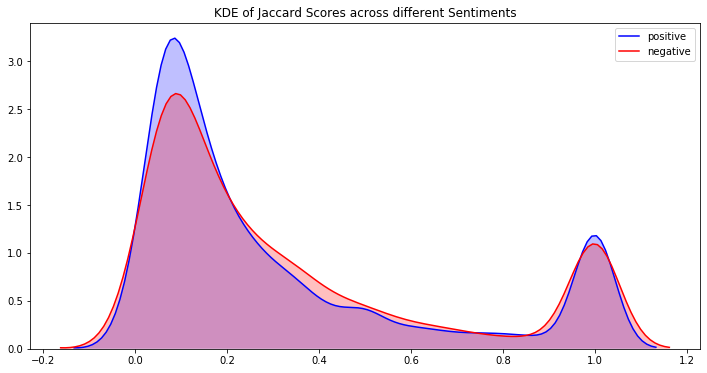

In [21]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(pos['jaccard_score'], shade=True, color="b").\
    set_title('KDE of Jaccard Scores across different Sentiments')
p2=sns.kdeplot(neg['jaccard_score'], shade=True, color="r")
#p3=sns.kdeplot(train[train['sentiment']=='neutral']['jaccard_score'],
#              shade=True,color="g")
# Neutral is blowing this KDE up, lets look at that in the below.
plt.legend(labels=['positive','negative'])

Text(0.5, 1.0, 'Histogram of Jaccard Score for neutral sentiment.')

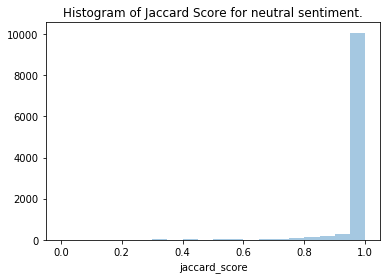

In [22]:
sns.distplot(neutral['jaccard_score'], bins = 20, kde = False).\
    set_title('Histogram of Jaccard Score for neutral sentiment.')

This is great, this makes things very simple (mostly) for neutral sentiment tweets.  It looks like neutral tweets have a Jaccard score of 1.0, which means that the selected text has all of the original text is in the selected text.  There are some differences though, lets look at a few below.

In [23]:
neutral[neutral['jaccard_score'] < 0.5][['text', 'selected_text','jaccard_score']]

,text,selected_text,jaccard_score
531,"_terrible haha, that was new the fact that he...",he couldn`t do it should have cost his part.,0.409091
556,Thank you I`ve had anxiety issues for years...,Thank you I`ve had anxiety issues,0.240000
685,Didn`t get bitten by a rabies infested person ...,"! Gonna scare Rachel with Quarantine tonight, ...",0.416667
1033,??????? #bash ?? ??????? ????????? ????,#bash,0.200000
1209,Went and saw Fighting last night with the best...,. It wasn`t all that great but Channing Tatum ...,0.476190
...,...,...,...
26230,check out review for the movie Fighting - htt...,Hilarious,0.000000
26331,Lol...I am greedy. I`m craving Coldstone again.,m greedy.,0.125000
26561,"Ive been up since 530,i hate wen i cant sleep....",i hate wen i cant sleep.,0.263158
27037,can`t sleep so i`m watching some more Gilmore ...,can`t sleep so,0.333333


Looking at the above, we can see a few things that are removed: website links, standalone symbols, a few other things.  I am not sure I can look at these specifically.  This is definately a very unique situation though.  The other sentiments 

In [24]:
neutral.loc[26230,'text'] # Selected text for this one is just 'Hilarious'.

' check out review for the movie Fighting - http://bit.ly/Fle9j  Hilarious!! leave this guy a comment!'

In [45]:
buckets = np.linspace(min(train_f.text_word_count), max(train_f.text_word_count), 10)
train_f.groupby(pd.cut(train_f['text_word_count'], buckets)).mean()

,text_length,text_word_count,text_contains_profanity,difference_in_text,jaccard_score
text_word_count,,,,,
"(0.0, 3.556]",13.286395,2.436210,0.024881,0.434092,0.838544
"(3.556, 7.111]",28.182108,5.573515,0.032561,1.821081,0.687307
"(7.111, 10.667]",44.959717,8.956618,0.041169,3.699425,0.592782
"(10.667, 14.222]",62.225762,12.442422,0.053819,5.801345,0.543238
"(14.222, 17.778]",80.168576,15.960720,0.057938,7.926350,0.512378
"(17.778, 21.333]",98.049568,19.465052,0.066555,9.688388,0.511140
"(21.333, 24.889]",113.247322,22.941779,0.058221,12.203074,0.479669
"(24.889, 28.444]",121.472151,25.998286,0.053128,12.835476,0.517344
"(28.444, 32.0]",127.541667,29.583333,0.052083,15.677083,0.486601


In [49]:
buckets = np.linspace(min(train_f.text_word_count), max(train_f.text_word_count), 11)
train_f.groupby(['sentiment', pd.cut(train_f['text_word_count'], buckets)])['text_word_count', 'jaccard_score'].mean()

text_word_count  jaccard_score
sentiment text_word_count                                
negative  (0.0, 3.2]              2.597183       0.687230
          (3.2, 6.4]              5.070423       0.504175
          (6.4, 9.6]              8.002978       0.375871
          (9.6, 12.8]            10.968537       0.320440
          (12.8, 16.0]           14.423341       0.266108
          (16.0, 19.2]           17.984936       0.248560
          (19.2, 22.4]           20.961992       0.238460
          (22.4, 25.6]           23.884342       0.233359
          (25.6, 28.8]           26.669456       0.224584
          (28.8, 32.0]           29.781250       0.164405
neutral   (0.0, 3.2]              2.367126       0.975206
          (3.2, 6.4]              4.997982       0.981812
          (6.4, 9.6]              7.975674       0.982781
          (9.6, 12.8]            10.966328       0.979127
          (12.8, 16.0]           14.414855       0.975341
          (16.0, 19.2]           17.997135       0.971480
          (19.2, 22.4]           20.947257       0.965618
          (22.4, 25.6]           23.895265       0.966990
          (25.6, 28.8]           26.741573       0.966922
          (28.8, 32.0]           29.388889       0.997778
positive  (0.0, 3.2]              2.461390       0.674196
          (3.2, 6.4]              5.095277       0.464738
          (6.4, 9.6]              7.973333       0.339255
          (9.6, 12.8]            11.023664       0.291372
          (12.8, 16.0]           14.433925       0.243152
          (16.0, 19.2]           17.966254       0.218568
          (19.2, 22.4]           20.935323       0.210792
          (22.4, 25.6]           23.779089       0.190190
          (25.6, 28.8]           26.584211       0.186810
          (28.8, 32.0]           29.607143       0.197597

# Last look before we start slicing, dicing, and predicting
First of all, I relly like the above display.  It shows in one table what I have seen in some of the other above analytics.  Neutral sentiment tweets have a very high jaccard score, meaning the selected text is very close to the source text, no removing of stop words.  Also, shorter words seem to have a high jaccard score.  Source tweets three(ish) words or shorter have a very high jaccard score, regardless of the sentiment.  When looking to train these models, I may split them up based on the length of the input.  If there is super high correlation between very short tweets and the selected text, I don't want to necessarily inlcude that in my modeling or training as it could mess up the signals of more complex tweets.

One thing I dont mention above is that selected texts are subsets of the original text maintaining order.  This means if a text is 'Hello, how are you doing?', the selcted text can NOT be 'Hello, you doing?'.

To summarize here is what I am going to do to fit the training data:
    - Break out training to the different sentiments, only training positive and negative, neutral will be 1:1
    - Trim out all tweets with less than or equal to three words, those will be 1:1

In [8]:
# I am just going to reload these to ensure no funny business, also, they are small so no real inneffiency.
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
ex_submission = pd.read_csv('sample_submission.csv')

train_df['num_of_words'] = train_df['text'].apply(lambda l: len(str(l).split()))
train_df = train_df[train_df['num_of_words'] >= 3]

In [49]:
# https://www.kaggle.com/rohitsingh9990/ner-training-using-spacy-ensemble

def save_model(output_dir : str, nlp : spacy.lang.en.English, model_name : str) -> None:
    current_file_path = os.getcwd()
    output_file_path = f'{current_file_path}/{output_dir}'
    if output_file_path is not None:        
        if not os.path.exists(output_file_path):
            os.makedirs(output_file_path)
        nlp.meta["name"] = model_name
        nlp.to_disk(output_dir)
        print("Saved model to", output_file_path)
    
def format_data(sentiment : str, data : pd.DataFrame) -> list:
    # Returns training data in the format needed to train spacy NER
    # A list the contains the raw text, followed by a 'coordinates' of the selcted text.
    data_formatted = []
    for index, row in data.iterrows():
        if row.sentiment == sentiment:
            selected_text = row.selected_text
            text = row.text
            start = text.find(selected_text) # What character number in the text does the selected text start
            end = start + len(selected_text) # What character number in the text does the selected text end
            data_formatted.append((text, {"entities": [[start, end, 'selected_text']]}))
    return data_formatted

def get_model_out_path(str : sentiment) -> str:
    model_out_path = None
    if sentiment == 'positive':
        model_out_path = 'Models/pos_model'
    elif sentiment == 'negative':
        model_out_path = 'Models/neg_model'
    return model_out_path

def train_model(train_data : list, output_dir: str, 
                n_iter : int = 20, model : str = None) -> None #spacy.lang.en.English:
    # If we are creating a model from scratch, pass model = None, else we need to pass it a file path.
    if model is not None:
        nlp = spacy.load(output_dir)  # load existing spaCy model
        print("Loaded model '%s'" % model)
    else:
        nlp = spacy.blank('en')  # create blank Language class
        print("Created blank 'en' model")
    
    # create the built-in pipeline components and add them to the pipeline
    # nlp.create_pipe works for built-ins that are registered with spaCy
    # This is tripped if this is a new model.  We need to establish this as a NER problem, and only a NER problem.
    if 'ner' not in nlp.pipe_names:
        ner = nlp.create_pipe('ner')
        nlp.add_pipe(ner, last = True)
    # Otherwise, pull the NER data to further train on it.
    else:
        ner = nlp.get_pipe('ner')
    
    # add labels
    for _, annotations in train_data:
        for ent in annotations.get('entities'):
            ner.add_label(ent[2])

    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
    with nlp.disable_pipes(*other_pipes):  # remove all pipes, leaving only NER
        # sizes = compounding(1.0, 4.0, 1.001)
        # batch up the examples using spaCy's minibatch
        if model is None:
            nlp.begin_training()
        else:
            nlp.resume_training()

        for itn in tqdm(range(n_iter)):
            random.shuffle(train_data) # Shuffles the data in place.
            batches = minibatch(train_data, size = compounding(4.0, 500.0, 1.001)) 
            # minibatch - breaks the data into size-number of groups, no repetition
            # compounding - this yields a continuous stream of sizes.
            # first iteration : 4, next : 4 * 1.001, next : 4 * 1.001**2, ..., max : 500
            # This makes it so that the batches get bigger as we increase the iterations.
            losses = {}
            for batch in batches:
                texts, annotations = zip(*batch) # This effectively creates the left and right side of the ML
                nlp.update(texts,         # batch of texts
                            annotations,  # batch of annotations
                            drop = 0.5,   # dropout - make it harder to memorise data
                            losses = losses)
            print("Losses", losses)
            
    save_model(output_dir = output_dir, nlp = nlp, model_name = sentiment + '_mod')
    # return nlp

This code is going to be an example of named-entity recognition (NER).  NER is a subtask of information extraction, that seeks out and catgorizes specific entities in a body of text.  In this example, we are looking to identify the 'specific entity', in this case selected text, in each of the parent text.  This will use the library spaCy which, among NER, also specializes in tokenization, parts-of-speech tagging, and text classification.

In [111]:
iterations = 50
sentiment = 'positive'

train_formatted = format_data(sentiment = sentiment, data = train_df)
model_path = get_model_out_path(sentiment)

train_model(train_data = train_formatted, output_dir = model_path, n_iter = iterations, model = None)

  0%|          | 0/20 [00:00<?, ?it/s]

Created blank 'en' model


  5%|▌         | 1/20 [00:29<09:24, 29.72s/it]

Losses {'ner': 32869.27489424421}


 10%|█         | 2/20 [00:59<08:56, 29.78s/it]

Losses {'ner': 30377.24039293486}


 15%|█▌        | 3/20 [01:30<08:31, 30.07s/it]

Losses {'ner': 29057.124808851207}


 20%|██        | 4/20 [02:01<08:06, 30.42s/it]

Losses {'ner': 27892.40166774144}


 25%|██▌       | 5/20 [02:33<07:42, 30.80s/it]

Losses {'ner': 27145.746138441675}


 30%|███       | 6/20 [03:03<07:09, 30.66s/it]

Losses {'ner': 26296.19062585613}


 35%|███▌      | 7/20 [03:33<06:36, 30.48s/it]

Losses {'ner': 25707.94161039412}


 40%|████      | 8/20 [04:08<06:20, 31.68s/it]

Losses {'ner': 25539.36573310011}


 45%|████▌     | 9/20 [04:44<06:05, 33.18s/it]

Losses {'ner': 25275.274196895603}


 50%|█████     | 10/20 [05:22<05:43, 34.37s/it]

Losses {'ner': 24577.08206046719}


 55%|█████▌    | 11/20 [05:58<05:16, 35.12s/it]

Losses {'ner': 23951.152349313947}


 60%|██████    | 12/20 [06:35<04:45, 35.72s/it]

Losses {'ner': 23757.19754391586}


 65%|██████▌   | 13/20 [07:13<04:13, 36.18s/it]

Losses {'ner': 23052.846751051547}


 70%|███████   | 14/20 [07:50<03:38, 36.39s/it]

Losses {'ner': 22983.097606711024}


 75%|███████▌  | 15/20 [08:27<03:03, 36.67s/it]

Losses {'ner': 22811.52174470717}


 80%|████████  | 16/20 [09:04<02:27, 36.80s/it]

Losses {'ner': 22338.714516710646}


 85%|████████▌ | 17/20 [09:41<01:50, 36.92s/it]

Losses {'ner': 23131.103971287328}


 90%|█████████ | 18/20 [10:18<01:13, 36.96s/it]

Losses {'ner': 22212.30763782833}


 95%|█████████▌| 19/20 [10:55<00:36, 36.98s/it]

Losses {'ner': 21737.19247097857}


100%|██████████| 20/20 [11:33<00:00, 34.66s/it]

Losses {'ner': 21539.232152217304}
Saved model to /Users/andrewcoogan/Documents/Source Control/Tweet Sentiment/Models/pos_model


In [112]:
sentiment = 'negative'

train_formatted = format_data(sentiment = sentiment, data = train_df)
model_path = get_model_out_path(sentiment)

train_model(train_data = train_formatted, output_dir = model_path, n_iter = iterations, model = None)

  0%|          | 0/20 [00:00<?, ?it/s]

Created blank 'en' model


  5%|▌         | 1/20 [00:28<09:08, 28.86s/it]

Losses {'ner': 30999.663995688665}


 10%|█         | 2/20 [00:57<08:37, 28.74s/it]

Losses {'ner': 27769.699119837962}


 15%|█▌        | 3/20 [01:25<08:07, 28.67s/it]

Losses {'ner': 26182.94335998482}


 20%|██        | 4/20 [01:54<07:40, 28.79s/it]

Losses {'ner': 25297.42207167722}


 25%|██▌       | 5/20 [02:25<07:18, 29.22s/it]

Losses {'ner': 24321.378325956}


 30%|███       | 6/20 [02:54<06:49, 29.28s/it]

Losses {'ner': 23297.01331068534}


 35%|███▌      | 7/20 [03:23<06:19, 29.21s/it]

Losses {'ner': 22490.969663270644}


 40%|████      | 8/20 [03:53<05:53, 29.44s/it]

Losses {'ner': 22595.873792664992}


 45%|████▌     | 9/20 [04:27<05:39, 30.84s/it]

Losses {'ner': 21414.76720212736}


 50%|█████     | 10/20 [05:03<05:22, 32.27s/it]

Losses {'ner': 21028.15290060364}


 55%|█████▌    | 11/20 [05:38<04:59, 33.27s/it]

Losses {'ner': 20962.325845219093}


 60%|██████    | 12/20 [06:14<04:31, 34.00s/it]

Losses {'ner': 20458.831599740748}


 65%|██████▌   | 13/20 [06:50<04:01, 34.49s/it]

Losses {'ner': 20171.927317815782}


 70%|███████   | 14/20 [07:25<03:29, 34.87s/it]

Losses {'ner': 20081.363566664055}


 75%|███████▌  | 15/20 [08:01<02:55, 35.17s/it]

Losses {'ner': 19518.34055256315}


 80%|████████  | 16/20 [08:37<02:21, 35.31s/it]

Losses {'ner': 19138.704818701248}


 85%|████████▌ | 17/20 [09:13<01:46, 35.41s/it]

Losses {'ner': 18672.921597264234}


 90%|█████████ | 18/20 [09:49<01:11, 35.56s/it]

Losses {'ner': 18406.95251419927}


 95%|█████████▌| 19/20 [10:24<00:35, 35.62s/it]

Losses {'ner': 18735.659574015284}


100%|██████████| 20/20 [11:00<00:00, 33.02s/it]

Losses {'ner': 18401.22915177611}
Saved model to /Users/andrewcoogan/Documents/Source Control/Tweet Sentiment/Models/neg_model


In [121]:
def predict_entities(text : str, model) -> str:
    doc = model(text)
    ent_array = []
    for ent in doc.ents:
        start = text.find(ent.text)
        end = start + len(ent.text)
        new_int = [start, end, ent.label_]
        if new_int not in ent_array:
            ent_array.append([start, end, ent.label_])
    selected_text = text[ent_array[0][0]: ent_array[0][1]] if len(ent_array) > 0 else text
    return selected_text

In [129]:
'''
model_pos = spacy.load(os.getcwd() + '/Models/pos_model')
model_neg = spacy.load(os.getcwd() + '/Models/neg_model')

jaccard_score = 0

for index, row in tqdm(train_df.iterrows(), total=train_df.shape[0]):
    if row.num_of_words <= 2 or row.sentiment == 'neutral':
        jaccard_score += jaccard(row.text, row.selected_text)
    elif row.sentiment == 'positive':
        jaccard_score += jaccard(predict_entities(row.text, model_pos), row.selected_text)
    elif row.sentiment == 'negative':
        jaccard_score += jaccard(predict_entities(row.text, model_neg), row.selected_text)

print(f'Average Jaccard Score is {jaccard_score / train_df.shape[0]}') 
'''

"\nmodel_pos = spacy.load(os.getcwd() + '/Models/pos_model')\nmodel_neg = spacy.load(os.getcwd() + '/Models/neg_model')\n\njaccard_score = 0\n\nfor index, row in tqdm(train_df.iterrows(), total=train_df.shape[0]):\n    if row.num_of_words <= 2 or row.sentiment == 'neutral':\n        jaccard_score += jaccard(row.text, row.selected_text)\n    elif row.sentiment == 'positive':\n        jaccard_score += jaccard(predict_entities(row.text, model_pos), row.selected_text)\n    elif row.sentiment == 'negative':\n        jaccard_score += jaccard(predict_entities(row.text, model_neg), row.selected_text)\n\nprint(f'Average Jaccard Score is {jaccard_score / train_df.shape[0]}') \n"